In [244]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, f1_score, fbeta_score, brier_score_loss, recall_score
from sklearn.datasets import make_classification
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.datasets import make_classification
import lightgbm as lgb
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

# Reading Datasets

In [245]:
df1 = pd.read_csv('../Data/Edited_bitsM.csv') # Contains 300 negatives and 36 positives from BITSM
df2 = pd.read_csv('../Data/ESIdf.csv') # Contains 75 positives from ESI

df1.head()

,Unnamed: 0,Gender,Age,Haemoglobin(gms%),Total WBC Count(/Cumm),Neutrophils(%),Lymphocytes(%),Eosinophils(%),Monocytes(%),Basophils(%),Others,Total RBC Count(millions/Cu),HCT(%),MCV(f L),MCH(pg),MCHC(gms%),RDWCV(%),Platelet Count(Lakh / Cumm),Result
0,0,Male,63.0,11.6,10200,72,23,2,3,0,0,4.20,35.0,84.0,28.3,33.7,14.4,2.20,Negative
1,1,Female,27.0,13.7,7100,63,34,1,2,0,0,4.36,40.1,92.0,31.3,34.1,14.1,2.48,Negative
2,2,Male,63.0,11.1,8500,59,35,3,3,0,0,4.00,33.5,84.0,27.9,33.3,14.0,2.68,Negative
3,3,Male,35.0,14.0,5500,45,50,2,3,0,0,4.73,42.0,89.0,29.7,33.4,14.3,2.34,Negative
4,4,Male,19.0,13.2,5100,61,33,3,3,0,0,3.27,42.2,80.0,25.1,31.4,15.4,1.94,Negative


In [246]:
# Creating the external dataset validation for Indian model
external_validation_df = df1[df1['Result'] == 'Positive']

In [247]:
df1 = df1[df1['Result'] != 'Positive'] # Removing positives from the training set of BITSM
# Now, df1 contains 300 negatives from BITSM and df2 contains 75 positives from ESI

In [248]:
# Creating the training dataset by merging df1 and df2
df = pd.concat([df1, df2], join = 'inner')

# Preprocessing data

In [249]:
encoder = LabelEncoder()

df['Result'] = encoder.fit_transform(df['Result'])  
df['Gender'] = encoder.fit_transform(df['Gender'])

In [250]:
df = df.drop(columns = [df.columns[0], 'Others'])

#Prepare for training and testing
X = df.drop(columns = ['Result'])
Y = df['Result']

## Creation of SMOTE dataset

In [251]:
smote = SMOTE(random_state=42)

In [252]:
X_resampled, Y_resampled = smote.fit_resample(X, Y)

df_smote = pd.DataFrame(X_resampled, columns = X.columns)
df_smote['Result'] = Y_resampled

In [253]:
for x in df_smote.columns:
    df_smote[x] = df_smote[x].apply(lambda x : round(x, 2))       #rounding till 2, but age to int, and haemo to 1

df_smote['Age'] = df_smote['Age'].apply(lambda x : int(x))
df_smote['Haemoglobin(gms%)'] = df_smote['Haemoglobin(gms%)'].apply(lambda x : round(x, 1))

In [254]:
# df_smote.to_csv('../Data/smoteesimedc.csv') 

In [255]:
# dropping gender and age columns from both the datasets because we are not considering them
df = df.drop(columns = ['Gender', 'Age'])
df_smote = df_smote.drop(columns = ['Gender', 'Age'])

## Training 4 models on 375 dataset

In [256]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# 80:20 split on the 375 dataset (df)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Result', axis=1), df['Result'], test_size=0.2, random_state=42, stratify=df['Result'])

# Define models and their parameter grids (with random_state=42 for reproducibility)
models = {
    'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1]
    }),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1, 1.0]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5, 7]
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'model__max_depth': [3, 5, 7, None],
        'model__criterion': ['gini', 'entropy']
    })
}

best_estimators = {}
results = {}

for name, (model, param_grid) in models.items():
    print(f"\nTraining {name} with SelectKBest...")
    pipe = Pipeline([
        ('select', SelectKBest(score_func=f_classif)),
        ('model', model)
    ])
    # Add k to param_grid
    param_grid_with_k = param_grid.copy()
    param_grid_with_k['select__k'] = [5, 8, 'all']
    grid = GridSearchCV(pipe, param_grid_with_k, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    results[name] = {
        'best_params': grid.best_params_,
        'train_score': grid.best_score_,
        'test_score': grid.best_estimator_.score(X_test, y_test)
    }
    print(f"Best params: {grid.best_params_}")
    print(f"Train CV accuracy: {grid.best_score_:.4f}")
    print(f"Test accuracy: {grid.best_estimator_.score(X_test, y_test):.4f}")


Training XGBoost with SelectKBest...
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'select__k': 'all'}
Train CV accuracy: 0.9667
Test accuracy: 0.9733

Training AdaBoost with SelectKBest...
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'select__k': 'all'}
Train CV accuracy: 0.9667
Test accuracy: 0.9733

Training AdaBoost with SelectKBest...
Best params: {'model__learning_rate': 1.0, 'model__n_estimators': 50, 'select__k': 'all'}
Train CV accuracy: 0.9600
Test accuracy: 0.9867

Training RandomForest with SelectKBest...
Best params: {'model__learning_rate': 1.0, 'model__n_estimators': 50, 'select__k': 'all'}
Train CV accuracy: 0.9600
Test accuracy: 0.9867

Training RandomForest with SelectKBest...
Best params: {'model__max_depth': 7, 'model__n_estimators': 100, 'select__k': 5}
Train CV accuracy: 0.9600
Test accuracy: 0.9467

Training DecisionTree with SelectKBest...
Best params: {'model__max_

In [257]:
import os
import joblib

MODELS_DIR = '../Models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Display summary of results for all models and print best features

def get_selected_features(pipe, feature_names):
    selector = pipe.named_steps['select']
    if hasattr(selector, 'get_support'):
        mask = selector.get_support()
        return list(feature_names[mask])
    return []

feature_names = X_train.columns if 'X_train' in locals() else df.drop('Result', axis=1).columns

display_results = []
for name, res in results.items():
    model_path = os.path.join(MODELS_DIR, f'best_{name}_original.pkl')
    if os.path.exists(model_path):
        print(f"Loading {name} model from {model_path}")
        best_pipe = joblib.load(model_path)
    else:
        best_pipe = best_estimators[name]
        joblib.dump(best_pipe, model_path)
        print(f"Saved {name} model to {model_path}")
    selected_features = get_selected_features(best_pipe, feature_names)
    test_score = best_pipe.score(X_test, y_test)
    display_results.append({
        'Model': name,
        'Best Params': res['best_params'],
        'Selected Features': selected_features,
        'Train CV Accuracy': res['train_score'],
        'Test Accuracy': test_score
    })
    print(f"\n{name} selected features: {selected_features}")

import pandas as pd
df_results = pd.DataFrame(display_results)
df_results

Loading XGBoost model from ../Models\best_XGBoost_original.pkl

XGBoost selected features: ['Haemoglobin(gms%)', 'Total WBC Count(/Cumm)', 'Neutrophils(%)', 'Lymphocytes(%)', 'Eosinophils(%)', 'Monocytes(%)', 'Basophils(%)', 'Total RBC Count(millions/Cu)', 'HCT(%)', 'MCV(f L)', 'MCH(pg)', 'MCHC(gms%)', 'RDWCV(%)', 'Platelet Count(Lakh / Cumm)']
Loading AdaBoost model from ../Models\best_AdaBoost_original.pkl

AdaBoost selected features: ['Haemoglobin(gms%)', 'Total WBC Count(/Cumm)', 'Neutrophils(%)', 'Lymphocytes(%)', 'Eosinophils(%)', 'Monocytes(%)', 'Basophils(%)', 'Total RBC Count(millions/Cu)', 'HCT(%)', 'MCV(f L)', 'MCH(pg)', 'MCHC(gms%)', 'RDWCV(%)', 'Platelet Count(Lakh / Cumm)']
Loading RandomForest model from ../Models\best_RandomForest_original.pkl

RandomForest selected features: ['Total WBC Count(/Cumm)', 'Neutrophils(%)', 'Lymphocytes(%)', 'Eosinophils(%)', 'MCHC(gms%)']
Loading DecisionTree model from ../Models\best_DecisionTree_original.pkl

DecisionTree selected featur

,Model,Best Params,Selected Features,Train CV Accuracy,Test Accuracy
0,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...","[Haemoglobin(gms%), Total WBC Count(/Cumm), Ne...",0.966667,0.973333
1,AdaBoost,"{'model__learning_rate': 1.0, 'model__n_estima...","[Haemoglobin(gms%), Total WBC Count(/Cumm), Ne...",0.960000,0.986667
2,RandomForest,"{'model__max_depth': 7, 'model__n_estimators':...","[Total WBC Count(/Cumm), Neutrophils(%), Lymph...",0.960000,0.946667
3,DecisionTree,"{'model__criterion': 'entropy', 'model__max_de...","[Total WBC Count(/Cumm), Neutrophils(%), Lymph...",0.950000,0.920000


In [258]:
from sklearn.metrics import confusion_matrix, roc_auc_score

# Confusion matrix and metrics for XGBoost (original dataset)
xgb_pipe = joblib.load(os.path.join(MODELS_DIR, 'best_XGBoost_original.pkl'))
y_pred = xgb_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_pipe.predict_proba(X_test)[:,1])

# Sensitivity, specificity, accuracy
TN, FP, FN, TP = cm.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

print('XGBoost (Original) Confusion Matrix:')
print(cm)
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC: {auc:.4f}')

# Metrics table for all models (original dataset)
metrics_table = []
for name, res in results.items():
    pipe = joblib.load(os.path.join(MODELS_DIR, f'best_{name}_original.pkl'))
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]) if hasattr(pipe.named_steps['model'], 'predict_proba') else None
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    n_features = sum(pipe.named_steps['select'].get_support())
    metrics_table.append({
        'Model': name,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'AUC': auc,
        'Num Features': n_features
    })

metrics_df = pd.DataFrame(metrics_table)
print('\nOriginal Dataset Model Metrics:')
display(metrics_df)


XGBoost (Original) Confusion Matrix:
[[59  1]
 [ 1 14]]
Sensitivity: 0.9333
Specificity: 0.9833
Accuracy: 0.9733
AUC: 0.9878

Original Dataset Model Metrics:


,Model,Sensitivity,Specificity,Accuracy,AUC,Num Features
0,XGBoost,0.933333,0.983333,0.973333,0.987778,14
1,AdaBoost,0.933333,1.000000,0.986667,0.998889,14
2,RandomForest,0.800000,0.983333,0.946667,0.991111,5
3,DecisionTree,0.800000,0.950000,0.920000,0.875000,5


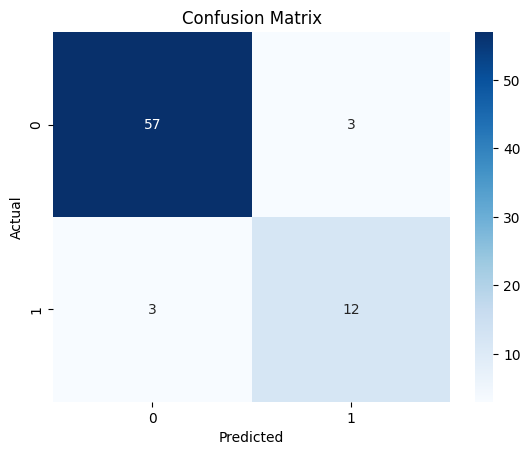

In [259]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [260]:
df_results.to_csv('../Results/India375.csv')

## Training on SMOTE (600)

In [261]:
import os
import joblib

MODELS_DIR = '../Models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Display summary of results for all models on SMOTE data and print best features

def get_selected_features(pipe, feature_names):
    selector = pipe.named_steps['select']
    if hasattr(selector, 'get_support'):
        mask = selector.get_support()
        return list(feature_names[mask])
    return []

feature_names_sm = X_train_sm.columns if 'X_train_sm' in locals() else df_smote.drop('Result', axis=1).columns

display_results_sm = []
for name, res in results_sm.items():
    model_path = os.path.join(MODELS_DIR, f'best_{name}_smote.pkl')
    if os.path.exists(model_path):
        print(f"Loading {name} model from {model_path}")
        best_pipe = joblib.load(model_path)
    else:
        best_pipe = best_estimators_sm[name]
        joblib.dump(best_pipe, model_path)
        print(f"Saved {name} model to {model_path}")
    selected_features = get_selected_features(best_pipe, feature_names_sm)
    test_score = best_pipe.score(X_test_sm, y_test_sm)
    display_results_sm.append({
        'Model': name,
        'Best Params': res['best_params'],
        'Selected Features': selected_features,
        'Train CV Accuracy': res['train_score'],
        'Test Accuracy': test_score
    })
    print(f"\n{name} selected features: {selected_features}")

df_results_sm = pd.DataFrame(display_results_sm)
df_results_sm

Loading XGBoost model from ../Models\best_XGBoost_smote.pkl

XGBoost selected features: ['Total WBC Count(/Cumm)', 'Neutrophils(%)', 'Lymphocytes(%)', 'Eosinophils(%)', 'Monocytes(%)', 'Total RBC Count(millions/Cu)', 'MCH(pg)', 'MCHC(gms%)']
Loading AdaBoost model from ../Models\best_AdaBoost_smote.pkl

AdaBoost selected features: ['Haemoglobin(gms%)', 'Total WBC Count(/Cumm)', 'Neutrophils(%)', 'Lymphocytes(%)', 'Eosinophils(%)', 'Monocytes(%)', 'Basophils(%)', 'Total RBC Count(millions/Cu)', 'HCT(%)', 'MCV(f L)', 'MCH(pg)', 'MCHC(gms%)', 'RDWCV(%)', 'Platelet Count(Lakh / Cumm)']
Loading RandomForest model from ../Models\best_RandomForest_smote.pkl

RandomForest selected features: ['Haemoglobin(gms%)', 'Total WBC Count(/Cumm)', 'Neutrophils(%)', 'Lymphocytes(%)', 'Eosinophils(%)', 'Monocytes(%)', 'Basophils(%)', 'Total RBC Count(millions/Cu)', 'HCT(%)', 'MCV(f L)', 'MCH(pg)', 'MCHC(gms%)', 'RDWCV(%)', 'Platelet Count(Lakh / Cumm)']
Loading DecisionTree model from ../Models\best_Decis

,Model,Best Params,Selected Features,Train CV Accuracy,Test Accuracy
0,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...","[Total WBC Count(/Cumm), Neutrophils(%), Lymph...",0.962500,0.983333
1,AdaBoost,"{'model__learning_rate': 1.0, 'model__n_estima...","[Haemoglobin(gms%), Total WBC Count(/Cumm), Ne...",0.966667,0.950000
2,RandomForest,"{'model__max_depth': 7, 'model__n_estimators':...","[Haemoglobin(gms%), Total WBC Count(/Cumm), Ne...",0.958333,0.966667
3,DecisionTree,"{'model__criterion': 'entropy', 'model__max_de...","[Haemoglobin(gms%), Total WBC Count(/Cumm), Ne...",0.935417,0.950000


In [262]:
# Confusion matrix and metrics for XGBoost (SMOTE dataset)
xgb_pipe_sm = joblib.load(os.path.join(MODELS_DIR, 'best_XGBoost_smote.pkl'))
y_pred_sm = xgb_pipe_sm.predict(X_test_sm)
cm_sm = confusion_matrix(y_test_sm, y_pred_sm)
auc_sm = roc_auc_score(y_test_sm, xgb_pipe_sm.predict_proba(X_test_sm)[:,1])

TN, FP, FN, TP = cm_sm.ravel()
sensitivity_sm = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity_sm = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy_sm = (TP + TN) / (TP + TN + FP + FN)

print('XGBoost (SMOTE) Confusion Matrix:')
print(cm_sm)
print(f'Sensitivity: {sensitivity_sm:.4f}')
print(f'Specificity: {specificity_sm:.4f}')
print(f'Accuracy: {accuracy_sm:.4f}')
print(f'AUC: {auc_sm:.4f}')

# Metrics table for all models (SMOTE dataset)
metrics_table_sm = []
for name, res in results_sm.items():
    pipe = joblib.load(os.path.join(MODELS_DIR, f'best_{name}_smote.pkl'))
    y_pred = pipe.predict(X_test_sm)
    cm = confusion_matrix(y_test_sm, y_pred)
    auc = roc_auc_score(y_test_sm, pipe.predict_proba(X_test_sm)[:,1]) if hasattr(pipe.named_steps['model'], 'predict_proba') else None
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    n_features = sum(pipe.named_steps['select'].get_support())
    metrics_table_sm.append({
        'Model': name,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'AUC': auc,
        'Num Features': n_features
    })

metrics_df_sm = pd.DataFrame(metrics_table_sm)
print('\nSMOTE Dataset Model Metrics:')
display(metrics_df_sm)


XGBoost (SMOTE) Confusion Matrix:
[[59  1]
 [ 1 59]]
Sensitivity: 0.9833
Specificity: 0.9833
Accuracy: 0.9833
AUC: 0.9994

SMOTE Dataset Model Metrics:


,Model,Sensitivity,Specificity,Accuracy,AUC,Num Features
0,XGBoost,0.983333,0.983333,0.983333,0.999444,8
1,AdaBoost,0.916667,0.983333,0.950000,0.980000,14
2,RandomForest,0.983333,0.950000,0.966667,0.998333,14
3,DecisionTree,0.933333,0.966667,0.950000,0.950000,14


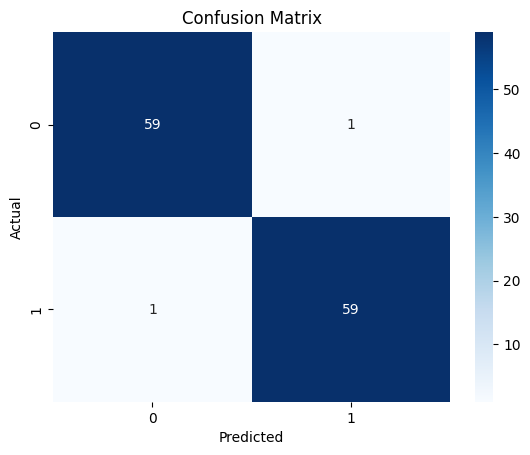

In [263]:
sns.heatmap(cm_sm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [264]:
df_results_sm.to_csv('../Results/IndiaSmote600.csv')